In [1]:
from __future__ import print_function

# Introduction
For this project I will attempt to create a prediction algorithom using the Random Forest method to predict the sale price of a group of homes in a test set of data. For this excersize I will use two separate sets of data. One that I wil use to train the model which contains the price of the final sale of the homes, and one that does not have the final sale price.   

In [2]:
#Import needed functions into the notebook 
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.decomposition import PCA
from sklearn.externals.six import StringIO
import os
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import scipy.stats as stats

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [3]:
#Read in the train data 
DATA_DIR = os.path.join("..","lol_project", "data")
DATA_DIR = os.path.abspath(DATA_DIR)

In [4]:
#Read in train data 
house_data  = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))


house_data_features = house_data.columns.get_values()
house_data_features = house_data_features.tolist()
#taking a look at what the features I'm working with 
print (house_data_features)


['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [5]:
#Take a look at the shape of the data 
house_data.shape

(1460, 81)

In [6]:
#Taking a look at the arrangement of the data I will want to rearrange the features by data type to engineer them
house_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [15]:
#reorder the df so that the data types are cleanly organized 
house_mask = pd.DataFrame(house_data.dtypes)
house_mask = house_mask.reset_index()
house_mask.columns = ['Col', 'dat_ty']
house_mask = house_mask.sort_values(['dat_ty'], ascending=[1])
house_data_columns = house_mask.Col.tolist()

In [9]:
# Check the mean and the median price of the data 
print (house_data.SalePrice.mean())
print (house_data.SalePrice.median())

180921.19589
163000.0


In [10]:
house_data = house_data[house_data_columns]
house_data.head()

,Id,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,...,Exterior1st,RoofMatl,RoofStyle,HouseStyle,BldgType,Condition2,KitchenQual,ExterCond,CentralAir,HeatingQC
0,1,150,856,856,854,0,1710,1,0,2,...,VinylSd,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Ex
1,2,284,1262,1262,0,0,1262,0,1,2,...,MetalSd,CompShg,Gable,1Story,1Fam,Norm,TA,TA,Y,Ex
2,3,434,920,920,866,0,1786,1,0,2,...,VinylSd,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Ex
3,4,540,756,961,756,0,1717,1,0,1,...,Wd Sdng,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Gd
4,5,490,1145,1145,1053,0,2198,1,0,2,...,VinylSd,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Ex


In [ ]:
# use this as a check to make sure the data reorganized
#house_data.dtypes

In [11]:
# Replace all the missing categorical data with "missing" creating an additional factor for the model. 
house_data_category_filled = house_data[house_data_columns[38:]].fillna("missing")
house_data_category_filled.head()

,Foundation,GarageFinish,LandSlope,LotConfig,GarageQual,GarageCond,LandContour,Utilities,GarageType,LotShape,...,Exterior1st,RoofMatl,RoofStyle,HouseStyle,BldgType,Condition2,KitchenQual,ExterCond,CentralAir,HeatingQC
0,PConc,RFn,Gtl,Inside,TA,TA,Lvl,AllPub,Attchd,Reg,...,VinylSd,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Ex
1,CBlock,RFn,Gtl,FR2,TA,TA,Lvl,AllPub,Attchd,Reg,...,MetalSd,CompShg,Gable,1Story,1Fam,Norm,TA,TA,Y,Ex
2,PConc,RFn,Gtl,Inside,TA,TA,Lvl,AllPub,Attchd,IR1,...,VinylSd,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Ex
3,BrkTil,Unf,Gtl,Corner,TA,TA,Lvl,AllPub,Detchd,IR1,...,Wd Sdng,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Gd
4,PConc,RFn,Gtl,FR2,TA,TA,Lvl,AllPub,Attchd,IR1,...,VinylSd,CompShg,Gable,2Story,1Fam,Norm,Gd,TA,Y,Ex


In [12]:
# use get_dummies to convert a categorical feature the models can understand 
house_data_dummies = pd.get_dummies(house_data_category_filled,drop_first=True).astype(int)
house_data_dummies.head()

,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_missing,LandSlope_Mod,LandSlope_Sev,...,KitchenQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,CentralAir_Y,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA
0,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [13]:
# replace missing float values with the mean of the rest of the data for that feature. 
mean_per_column = house_data[house_data_columns[35:38]].apply(
    lambda x: x.mean(), axis=0)
mean_per_column = mean_per_column.round(decimals=0)

house_data_float_missing = house_data[house_data_columns[35:38]].fillna(mean_per_column,axis=0)
house_data_float_missing.head()


,GarageYrBlt,LotFrontage,MasVnrArea
0,2003.0,65.0,196.0
1,1976.0,80.0,0.0
2,2001.0,68.0,162.0
3,1998.0,60.0,0.0
4,2000.0,84.0,350.0


In [ ]:
# checking for nulls in data set 
#house_data.isnull().sum()[0:40]

In [16]:
# create a new data frame that contains just the features that didn't get engineered
house_data_nonull = house_data[house_data_columns[:35]]
house_data_nonull.head()

,Id,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,EnclosedPorch,BsmtFinSF2,MSSubClass,...,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,BsmtUnfSF
0,1,0,0,0,0,2,2008,0,0,60,...,1,0,2,1,3,1,8,0,2,150
1,2,0,0,0,0,5,2007,0,0,20,...,0,1,2,0,3,1,6,1,2,284
2,3,0,0,0,0,9,2008,0,0,60,...,1,0,2,1,3,1,6,1,2,434
3,4,0,0,0,0,2,2006,272,0,70,...,1,0,1,0,3,1,7,1,3,540
4,5,0,0,0,0,12,2008,0,0,60,...,1,0,2,1,4,1,9,1,3,490


In [17]:
# Create a new DF by using concat the feature engineered df with the non feature engineered df
house_data_feature_engineered = pd.concat([house_data_nonull,house_data_float_missing,house_data_dummies],axis=1)

In [18]:
# a feature engineereed data set ready to run some modeling on 
house_data_feature_engineered.head()

,Id,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,EnclosedPorch,BsmtFinSF2,MSSubClass,...,KitchenQual_TA,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,CentralAir_Y,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA
0,1,0,0,0,0,2,2008,0,0,60,...,0,0,0,0,1,1,0,0,0,0
1,2,0,0,0,0,5,2007,0,0,20,...,1,0,0,0,1,1,0,0,0,0
2,3,0,0,0,0,9,2008,0,0,60,...,0,0,0,0,1,1,0,0,0,0
3,4,0,0,0,0,2,2006,272,0,70,...,0,0,0,0,1,1,0,1,0,0
4,5,0,0,0,0,12,2008,0,0,60,...,0,0,0,0,1,1,0,0,0,0


# Decision Tree
Here I will create a quick decision tree to get a baseline RMSE of which I will use to create the Random Forest Regression model.


In [20]:
# rearrange the data frame so sale price is on the end making it easier to plice out ID and Sale Price. 
house_data_feature_engineered = house_data_feature_engineered[['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'Alley_Pave',
 'Alley_missing',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Timber',
 'Neighborhood_Veenker',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_PosN',
 'Condition1_RRAe',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Feedr',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'BldgType_2fmCon',
 'BldgType_Duplex',
 'BldgType_Twnhs',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2.5Fin',
 'HouseStyle_2.5Unf',
 'HouseStyle_2Story',
 'HouseStyle_SFoyer',
 'HouseStyle_SLvl',
 'RoofStyle_Gable',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stone',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_BrkFace',
 'Exterior2nd_CBlock',
 'Exterior2nd_CmentBd',
 'Exterior2nd_HdBoard',
 'Exterior2nd_ImStucc',
 'Exterior2nd_MetalSd',
 'Exterior2nd_Other',
 'Exterior2nd_Plywood',
 'Exterior2nd_Stone',
 'Exterior2nd_Stucco',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Wd Shng',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'MasVnrType_missing',
 'ExterQual_Fa',
 'ExterQual_Gd',
 'ExterQual_TA',
 'ExterCond_Fa',
 'ExterCond_Gd',
 'ExterCond_Po',
 'ExterCond_TA',
 'Foundation_CBlock',
 'Foundation_PConc',
 'Foundation_Slab',
 'Foundation_Stone',
 'Foundation_Wood',
 'BsmtQual_Fa',
 'BsmtQual_Gd',
 'BsmtQual_TA',
 'BsmtQual_missing',
 'BsmtCond_Gd',
 'BsmtCond_Po',
 'BsmtCond_TA',
 'BsmtCond_missing',
 'BsmtExposure_Gd',
 'BsmtExposure_Mn',
 'BsmtExposure_No',
 'BsmtExposure_missing',
 'BsmtFinType1_BLQ',
 'BsmtFinType1_GLQ',
 'BsmtFinType1_LwQ',
 'BsmtFinType1_Rec',
 'BsmtFinType1_Unf',
 'BsmtFinType1_missing',
 'BsmtFinType2_BLQ',
 'BsmtFinType2_GLQ',
 'BsmtFinType2_LwQ',
 'BsmtFinType2_Rec',
 'BsmtFinType2_Unf',
 'BsmtFinType2_missing',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'HeatingQC_Po',
 'HeatingQC_TA',
 'CentralAir_Y',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'Electrical_missing',
 'KitchenQual_Fa',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'Functional_Maj2',
 'Functional_Min1',
 'Functional_Min2',
 'Functional_Mod',
 'Functional_Sev',
 'Functional_Typ',
 'FireplaceQu_Fa',
 'FireplaceQu_Gd',
 'FireplaceQu_Po',
 'FireplaceQu_TA',
 'FireplaceQu_missing',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_missing',
 'GarageFinish_RFn',
 'GarageFinish_Unf',
 'GarageFinish_missing',
 'GarageQual_Fa',
 'GarageQual_Gd',
 'GarageQual_Po',
 'GarageQual_TA',
 'GarageQual_missing',
 'GarageCond_Fa',
 'GarageCond_Gd',
 'GarageCond_Po',
 'GarageCond_TA',
 'GarageCond_missing',
 'PavedDrive_P',
 'PavedDrive_Y',
 'PoolQC_Fa',
 'PoolQC_Gd',
 'PoolQC_missing',
 'Fence_GdWo',
 'Fence_MnPrv',
 'Fence_MnWw',
 'Fence_missing',
 'MiscFeature_Othr',
 'MiscFeature_Shed',
 'MiscFeature_TenC',
 'MiscFeature_missing',
 'SaleType_CWD',
 'SaleType_Con',
 'SaleType_ConLD',
 'SaleType_ConLI',
 'SaleType_ConLw',
 'SaleType_New',
 'SaleType_Oth',
 'SaleType_WD',
 'SaleCondition_AdjLand',
 'SaleCondition_Alloca',
 'SaleCondition_Family',
 'SaleCondition_Normal',
 'SaleCondition_Partial',
 'SalePrice']]
house_data_feature_engineered.shape
house_data_feature_engineered.head()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,...,0,0,0,1,0,0,0,1,0,208500
1,2,20,9600,6,8,1976,1976,978,0,284,...,0,0,0,1,0,0,0,1,0,181500
2,3,60,11250,7,5,2001,2002,486,0,434,...,0,0,0,1,0,0,0,1,0,223500
3,4,70,9550,7,5,1915,1970,216,0,540,...,0,0,0,1,0,0,0,0,0,140000
4,5,60,14260,8,5,2000,2000,655,0,490,...,0,0,0,1,0,0,0,1,0,250000


In [21]:
#create a list of features that will be used in the model. 
house_data_engineered_col = house_data_feature_engineered.columns.get_values()
house_data_engineered_col = house_data_engineered_col.tolist()
house_data_engineered_col

['Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'Alley_Pave',
 'Alley_missing',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr'

In [22]:
# I will want to scale the data 
from sklearn.preprocessing import StandardScaler

In [23]:
#removing the sale price and id from the data 
house_data_engineered_col = house_data_engineered_col[1:262]
house_data_engineered_col

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'LotFrontage',
 'MasVnrArea',
 'GarageYrBlt',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'Alley_Pave',
 'Alley_missing',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Nei

In [24]:
X_dt = house_data_feature_engineered[house_data_engineered_col]
y_dt = house_data_feature_engineered.SalePrice

In [25]:
scaler = StandardScaler()
X_train_dt,X_test_dt,y_train_dt,y_test_dt = train_test_split(X_dt,y_dt,test_size=.4)

X_train_dt = scaler.fit_transform(X_train_dt)

X_test_dt = scaler.transform(X_test_dt)

In [50]:
decision_tree = DecisionTreeRegressor(max_depth = 17)
decision_tree.fit(X_train_dt,y_train_dt)
print("Decision Tree RMSE:",
      np.sqrt(mean_squared_error(y_test_dt, decision_tree.predict(X_test_dt))))

Decision Tree RMSE: 51838.2201851


Decision Tree Train/Test RMSE: 58887.44641   58321.5076216
Decision Tree Train/Test RMSE: 46098.8734394   58581.1824252
Decision Tree Train/Test RMSE: 37874.3351811   56858.692257
Decision Tree Train/Test RMSE: 32416.2898398   54556.2867534
Decision Tree Train/Test RMSE: 27187.1390765   52018.6349282
Decision Tree Train/Test RMSE: 21721.2521445   52614.8982675
Decision Tree Train/Test RMSE: 16914.4222848   52892.5765185
Decision Tree Train/Test RMSE: 13340.8169842   52173.9220907
Decision Tree Train/Test RMSE: 10383.7610143   51925.3619941
Decision Tree Train/Test RMSE: 7773.19598299   51545.2534143
Decision Tree Train/Test RMSE: 5769.72318552   43457.9072992
Decision Tree Train/Test RMSE: 4251.46370549   50077.1963256
Decision Tree Train/Test RMSE: 2974.83477279   52899.5865912
Decision Tree Train/Test RMSE: 2086.10516053   47936.8888638
Decision Tree Train/Test RMSE: 1463.31698344   45982.9706753
Decision Tree Train/Test RMSE: 984.992056633   51451.8241273
Decision Tree Train/Test RM

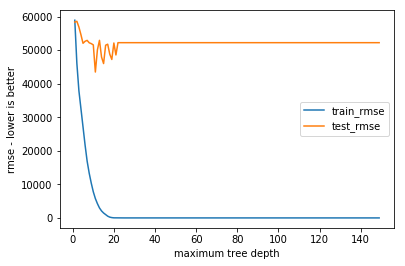

In [52]:
depths = range(1, 150)
train_rmse, test_rmse = [], []
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth, random_state=10)
    decision_tree.fit(X_train_dt, y_train_dt)
    curr_train_rmse = np.sqrt(
        mean_squared_error(y_train_dt, decision_tree.predict(X_train_dt)))
    curr_test_rmse = np.sqrt(
        mean_squared_error(y_test_dt, decision_tree.predict(X_test_dt)))
    
    print("Decision Tree Train/Test RMSE:", curr_train_rmse, " ",
          curr_test_rmse)
    
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths, train_rmse, label='train_rmse')
sns.mpl.pyplot.plot(depths, test_rmse, label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

Ok. So what we can see from creating a simple decision tree is that this will not be a good model to use for this use case. The RMSE is incredibly high. So let's try and do a random forest model. 

In [54]:
X_sale = house_data_feature_engineered[house_data_engineered_col]
y_sale = house_data_feature_engineered.SalePrice
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_sale, y_sale, test_size=0.4)

#scaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_rf)

#transform
X_test_scaled = scaler.transform(X_test_rf)

#pca fit
pca = PCA()

pca.fit(X_train_scaled)

#pca transform 
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#RF regressor model
rf_sale = RandomForestRegressor(n_estimators=400, bootstrap=True,oob_score=True, max_features = None, random_state=1234)
rf_sale.fit(X_train_pca, y_train_rf)
y_pred_rf_sale = rf_sale.predict(X_test_pca)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test_rf, y_pred_rf_sale)))

Random Forest RMSE: 32366.5875113


# We can see here that the RMSE has dropped a decent amount using the Random Forest Regressor

In [65]:
#compare the predictions to actual values 
predictions = pd.DataFrame({"Predictions":rf_sale.predict(X_test_pca), "Actual" : y_test_rf})
#predictions

In [68]:
# this code provides me with a test score of how well the model performed
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
predicted_train = rf_sale.predict(X_train_pca)
predicted_test = rf_sale.predict(X_test_pca)
test_score = r2_score(y_test_rf, predicted_test)
spearman = spearmanr(y_test_rf, predicted_test)
pearson = pearsonr(y_test_rf, predicted_test)
print (test_score)
#print (spearman)
print (pearson)

0.838621626064
(0.91927146005611804, 7.8215249191151562e-238)


In [61]:
# I used this code to determine the best number of estimaters in the model above. 
# list of values to try for n_estimators
estimator_range = range(400,500,20)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(
        n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1)
    
    rfreg.fit(X_train_pca, y_train_rf)
    preds = rfreg.predict(X_test_pca)
    rmse = np.sqrt(mean_squared_error(y_test_rf, preds))
    RMSE_scores.append(rmse)

Text(0,0.5,u'RMSE (lower is better)')

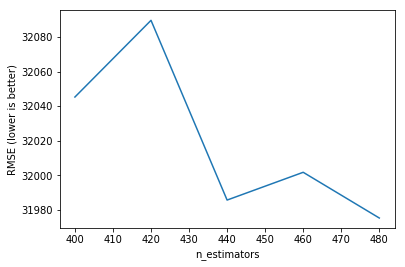

In [62]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
sns.mpl.pyplot.plot(estimator_range, RMSE_scores)
sns.mpl.pyplot.xlabel('n_estimators')
sns.mpl.pyplot.ylabel('RMSE (lower is better)')

# Read in new data 

Now the Random Forest regression model for predicting what the sale price of a will be has been made and tuned. Now I will read in another data set that does not contain the sale price and will use this model to predict what that price will be. 

 


In [73]:
#Read in the test data 
DATA_DIR = os.path.join("..","lol_project", "data")
DATA_DIR = os.path.abspath(DATA_DIR)

In [74]:
test_house_data  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))


test_house_data_features = test_house_data.columns.get_values()
test_house_data_features = test_house_data_features.tolist()
print (test_house_data_features)

['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC'

In [75]:
test_house_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [76]:
#reorder the df so that the data types are cleanly organized 
test_house_mask = pd.DataFrame(test_house_data.dtypes)
test_house_mask = test_house_mask.reset_index()
test_house_mask.columns = ['Col', 'dat_ty']
test_house_mask = test_house_mask.sort_values(['dat_ty'], ascending=[1])
test_house_col = test_house_mask.Col.tolist()
#test_house_col[1:]

In [77]:
# Replace all the missing categorical data with "missing" creating an additional factor for the model. 
test_house_data_category_filled = test_house_data[test_house_col[37:]].fillna("missing")
test_house_data_category_filled.head()

,FireplaceQu,KitchenQual,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,...,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,SaleType,HeatingQC,RoofMatl,SaleCondition
0,missing,TA,Attchd,Unf,TA,TA,Y,missing,MnPrv,missing,...,CBlock,TA,TA,No,Rec,LwQ,WD,TA,CompShg,Normal
1,missing,Gd,Attchd,Unf,TA,TA,Y,missing,missing,Gar2,...,CBlock,TA,TA,No,ALQ,Unf,WD,TA,CompShg,Normal
2,TA,TA,Attchd,Fin,TA,TA,Y,missing,MnPrv,missing,...,PConc,Gd,TA,No,GLQ,Unf,WD,Gd,CompShg,Normal
3,Gd,Gd,Attchd,Fin,TA,TA,Y,missing,missing,missing,...,PConc,TA,TA,No,GLQ,Unf,WD,Ex,CompShg,Normal
4,missing,Gd,Attchd,RFn,TA,TA,Y,missing,missing,missing,...,PConc,Gd,TA,No,ALQ,Unf,WD,Ex,CompShg,Normal


In [79]:
# use get_dummies to convert a categorical feature the models can understand 
test_house_data_dummies = pd.get_dummies(test_house_data_category_filled,drop_first=True).astype(int)
test_house_data_dummies.head()

,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,FireplaceQu_missing,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,KitchenQual_missing,GarageType_Attchd,...,HeatingQC_Po,HeatingQC_TA,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,1,0,0,1,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [80]:
# replace missing float values with the mean of the rest of the data. 
mean_per_column = test_house_data[test_house_col[26:37]].apply(
    lambda x: x.mean(), axis=0)
mean_per_column = mean_per_column.round(decimals=0)

test_house_data_float_missing = test_house_data[test_house_col[26:37]].fillna(mean_per_column,axis=0)
test_house_data_float_missing.head()

,BsmtHalfBath,TotalBsmtSF,BsmtUnfSF,BsmtFinSF2,BsmtFinSF1,GarageArea,GarageYrBlt,MasVnrArea,GarageCars,LotFrontage,BsmtFullBath
0,0.0,882.0,270.0,144.0,468.0,730.0,1961.0,0.0,1.0,80.0,0.0
1,0.0,1329.0,406.0,0.0,923.0,312.0,1958.0,108.0,1.0,81.0,0.0
2,0.0,928.0,137.0,0.0,791.0,482.0,1997.0,0.0,2.0,74.0,0.0
3,0.0,926.0,324.0,0.0,602.0,470.0,1998.0,20.0,2.0,78.0,0.0
4,0.0,1280.0,1017.0,0.0,263.0,506.0,1992.0,0.0,2.0,43.0,0.0


In [81]:
#Pull out the columns that don't have nulls 
test_house_data_sorted = test_house_data[test_house_col]
test_house_data_nonull = test_house_data_sorted[test_house_col[:26]]

In [82]:
# Create a new DF by concat the feature engineered df with the non fetaure engineered df
test_house_data_feature_engineered = pd.concat([test_house_data_nonull,test_house_data_float_missing,test_house_data_dummies],axis=1)

In [83]:
test_house_data_feature_engineered.columns.tolist()

['Id',
 'KitchenAbvGr',
 'GrLivArea',
 'BedroomAbvGr',
 'HalfBath',
 'YearRemodAdd',
 'YearBuilt',
 'OverallCond',
 'OverallQual',
 'FullBath',
 'TotRmsAbvGrd',
 'OpenPorchSF',
 'EnclosedPorch',
 'WoodDeckSF',
 'ScreenPorch',
 'MSSubClass',
 'YrSold',
 '3SsnPorch',
 'LotArea',
 'MoSold',
 'LowQualFinSF',
 '2ndFlrSF',
 '1stFlrSF',
 'PoolArea',
 'MiscVal',
 'Fireplaces',
 'BsmtHalfBath',
 'TotalBsmtSF',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtFinSF1',
 'GarageArea',
 'GarageYrBlt',
 'MasVnrArea',
 'GarageCars',
 'LotFrontage',
 'BsmtFullBath',
 'FireplaceQu_Fa',
 'FireplaceQu_Gd',
 'FireplaceQu_Po',
 'FireplaceQu_TA',
 'FireplaceQu_missing',
 'KitchenQual_Fa',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'KitchenQual_missing',
 'GarageType_Attchd',
 'GarageType_Basment',
 'GarageType_BuiltIn',
 'GarageType_CarPort',
 'GarageType_Detchd',
 'GarageType_missing',
 'GarageFinish_RFn',
 'GarageFinish_Unf',
 'GarageFinish_missing',
 'GarageQual_Gd',
 'GarageQual_Po',
 'GarageQual_TA',
 'GarageQual_missin

In [84]:
# Get_dummies created less overall features in this set. I have to balance out the number of features in order for the model to work 
# Get missing columns in the test data set 
missing_cols = set( house_data_feature_engineered.columns ) - set( test_house_data_feature_engineered.columns )
# Add a missing column in the new test set with default value equal to 0
for c in missing_cols:
    test_house_data_feature_engineered[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
test_house_data_feature_engineered = test_house_data_feature_engineered[house_data_feature_engineered.columns]

In [85]:
# scale and perform pca on the data set 
test_scaled = scaler.fit_transform(test_house_data_feature_engineered[test_house_data_feature_engineered.columns[1:262]])
test_pca = pca.fit_transform(test_scaled)

In [86]:
#generate the predictions
RandomForest_predict = rf_sale.predict(test_pca)
predictions = RandomForest_predict.tolist()

predictions = pd.DataFrame(np.array(predictions))

predictions.columns=['Predict_Sale_Price']

predictions.shape


(1459, 1)

In [92]:
prediction_csv = pd.concat([test_house_data['Id'],predictions],axis=1)

prediction_csv.to_csv('sale_price_prediction.csv')
